# Partitioned Circuit Extraction Walkthrough

Final phase of the circuit partioning framework is the extraction of a partitioned quanutm circuit. 

Using the QuantumCircuitHyperGraph object and a node assignment function, we can infer the required teleportation operations and build a quantum cirucit.
The qubits are split across multiple registers - one for each partition. Each partition is also initialised with a communication qubit register and a classical bit register for facilitating the teleportation. Additional communication qubits may be added if there are not enough available.

## Build initial circuit

First build/import and transpile the circuit. We use a fixed depth random circuit as an example.

W

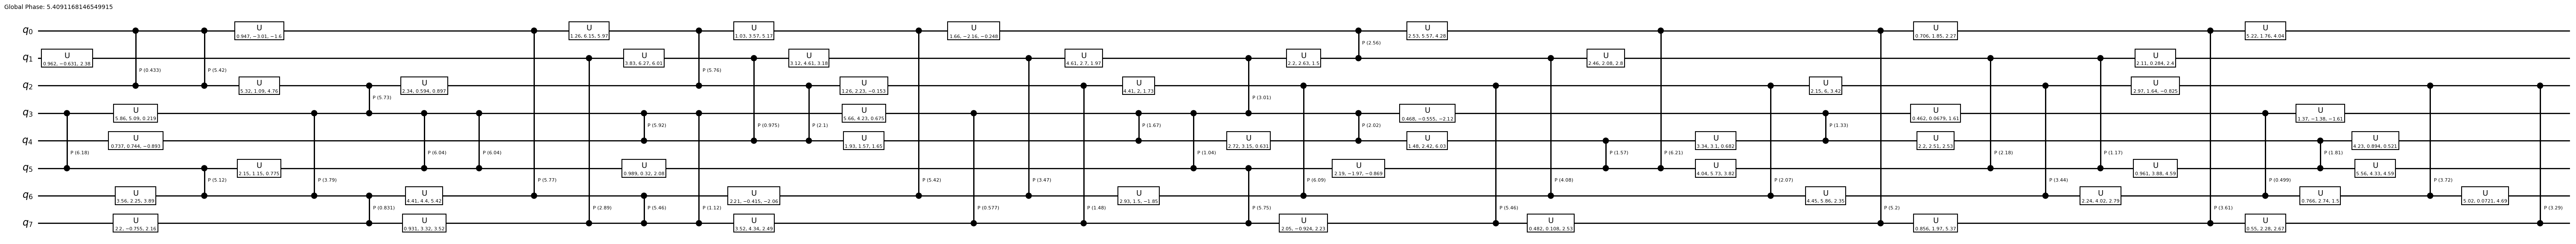

In [176]:
from circuits.cp_fraction import cp_fraction
from src.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from src.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from circuits.QAOA import QAOA_random
import numpy as np
from src.qiskit_to_op_list import *
from src.greedy_gate_grouping import group_distributable_packets

num_qubits = 8
circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=3*num_qubits,
                        fraction= 0.5)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()
circuit.draw(output='mpl', style='bw', fold = 100)


## Graph building

We then build the graph using the QuantumCircuitHyperGraph object. We also define the paremeteres of the QPU architecture using the qpu_info and comm_info variables, which tell us how many physical qubits are in each partition.

We can draw the resulting graph using matplotlib. 

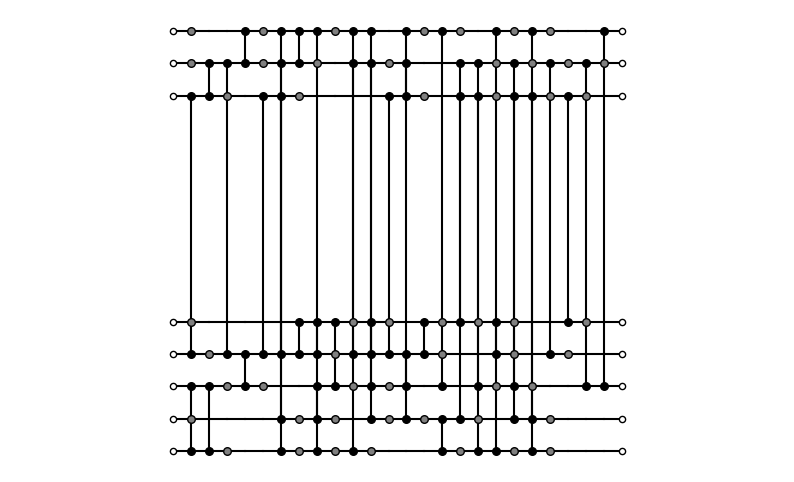

In [177]:
num_partitions = 2
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions
comm_info = [2] * num_partitions


group_gates = False

graph = QuantumCircuitHyperGraph(circuit = circuit,
                                 group_gates = group_gates,
                                 anti_diag = False)

assignment = set_initial_partitions(qpu_info = qpu_info, 
                                    num_qubits = num_qubits, 
                                    num_layers = depth, 
                                    num_partitions = num_partitions, 
                                    reduced = True)

from src.tikz_drawing import *
from src.mpl_drawing import *

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

## Naive extraction

We can first set a baseline for the distributed circuit by extracting a partitioned circuit directly from the unoptimised assignment function. This will likely result in a very deep circuit which does not use entanglement efficiently.

First import the extractor class, passing in the graph and the partition assignment that we initialised before.

In [178]:
from src.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                         partition_assignment=assignment, 
                                         qpu_info=qpu_info, 
                                         comm_info=comm_info)

basic_partitioned_circuit = extractor.extract_partitioned_circuit()

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

Depth of partitioned circuit: 32


We can draw the circuit to see where the teleportation blocks are occurring.

/Users/ftb123/anaconda3/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3394: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


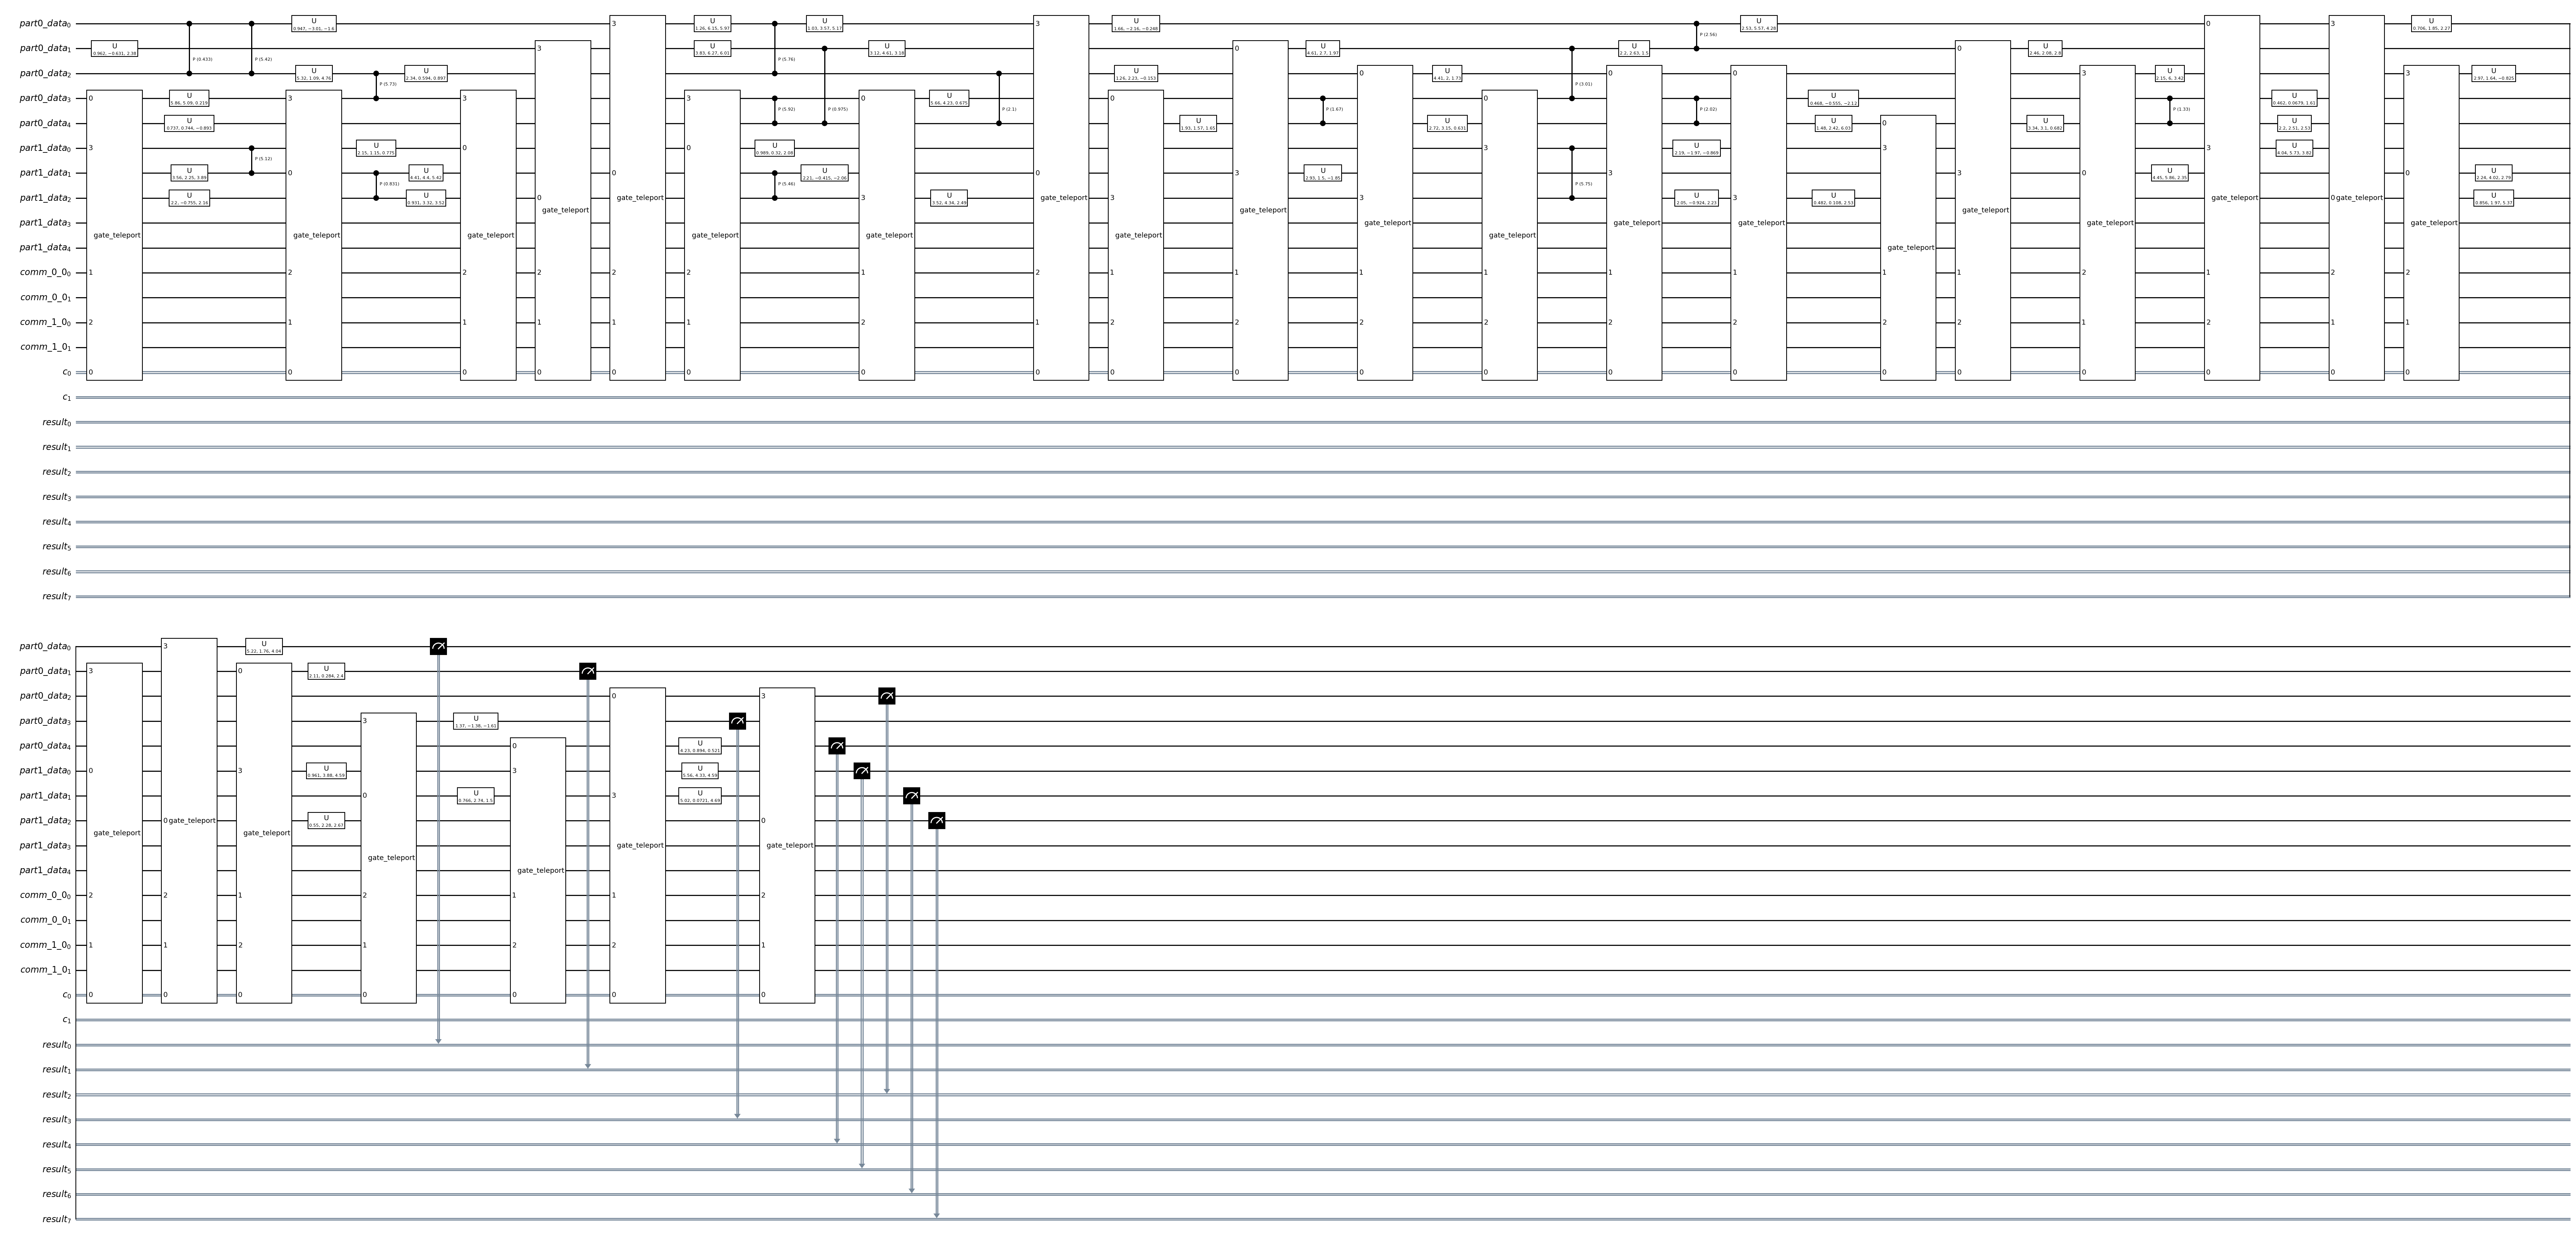

In [179]:
basic_partitioned_circuit.draw(output='mpl', style='bw', fold=100)

If we want to see the full depth, we will need to decompose the teleportation blocks into elementary operations.

In [180]:
decomposed_depth = basic_partitioned_circuit.decompose().decompose().depth()

print(f"Depth of decomposed partitioned circuit: {decomposed_depth}")

Depth of decomposed partitioned circuit: 299


We now optimise the node assignments using the recursive multilevel partitioning FM algorithm.

In [181]:
from src.multilevel_FM import MLFM_recursive

limit = 'qubit'

assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = 'qubit', 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = True,
                                        add_initial = False,
                                        costs = None)

optimised_assignment = assignment_list[np.argmin(cost_list)]

Initial cost: 27
All passes complete.
Final cost: 13
Best cost at level 0: 13
Initial cost: 13
All passes complete.
Final cost: 13
Best cost at level 1: 13
Initial cost: 13
All passes complete.
Final cost: 13
Best cost at level 2: 13
Initial cost: 13
All passes complete.
Final cost: 12
Best cost at level 3: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 4: 12
Initial cost: 12
All passes complete.
Final cost: 12
Best cost at level 5: 12


Now define a new extractor for with the optimised assignment. 

In [182]:
extractor_opt = PartitionedCircuitExtractor(graph = graph, 
                                            partition_assignment = optimised_assignment, 
                                            qpu_info = qpu_info, 
                                            comm_info=comm_info)

partitioned_circuit_opt = extractor_opt.extract_partitioned_circuit()


print(f"Depth of optimised partitioned circuit: {partitioned_circuit_opt.depth()}")

Depth of optimised partitioned circuit: 29


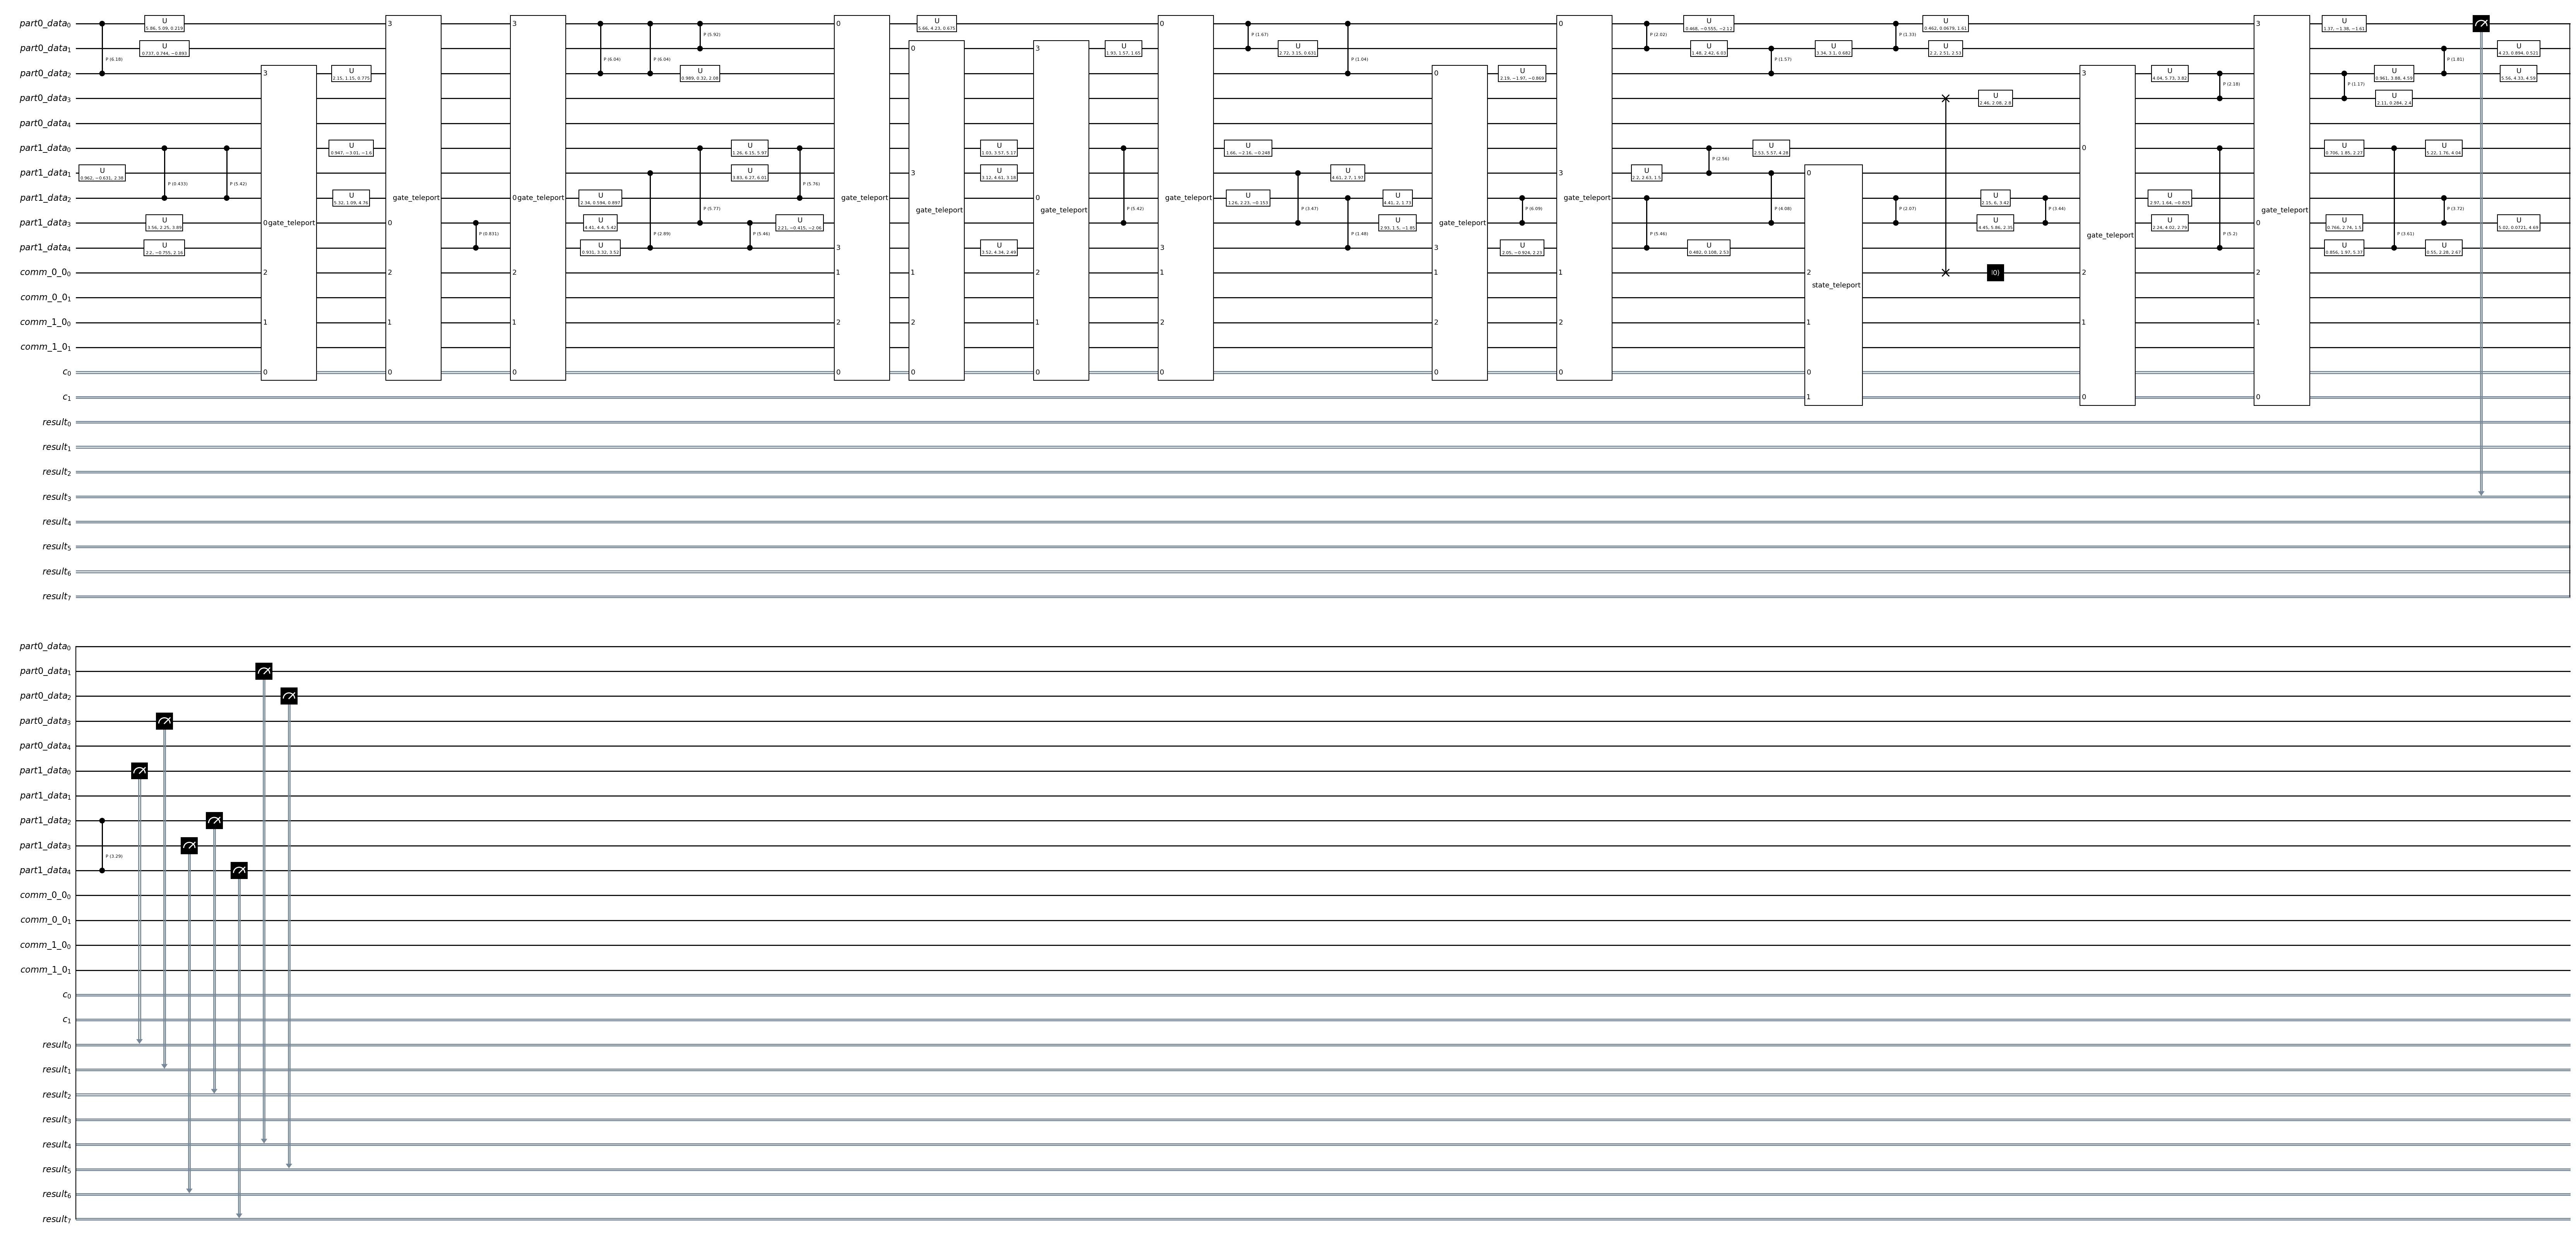

In [183]:
partitioned_circuit_opt.draw(output='mpl', style='bw', fold=100)

In [184]:
decomposed_depth_opt = partitioned_circuit_opt.decompose().decompose().depth()

print(f"Depth of decomposed partitioned circuit: {decomposed_depth_opt}")


Depth of decomposed partitioned circuit: 162


The depth of the resulting circuit should significantly lower than the unoptimised variant, though of course still much larger than the un-partitioned circuit. Some additional overhead is unavoidable.

## Validation

We would like to validate the output given by the partitioned circuit, which we can do using qiskits sampler class.

First we need to add measurements to the original, unpartitioned circuit.

In [185]:
from qiskit import ClassicalRegister

creg = ClassicalRegister(num_qubits, name="c")
measured_circuit = circuit.copy()
measured_circuit.add_register(creg)

for qubit in range(num_qubits):
    measured_circuit.measure(qubit, creg[qubit])


[]

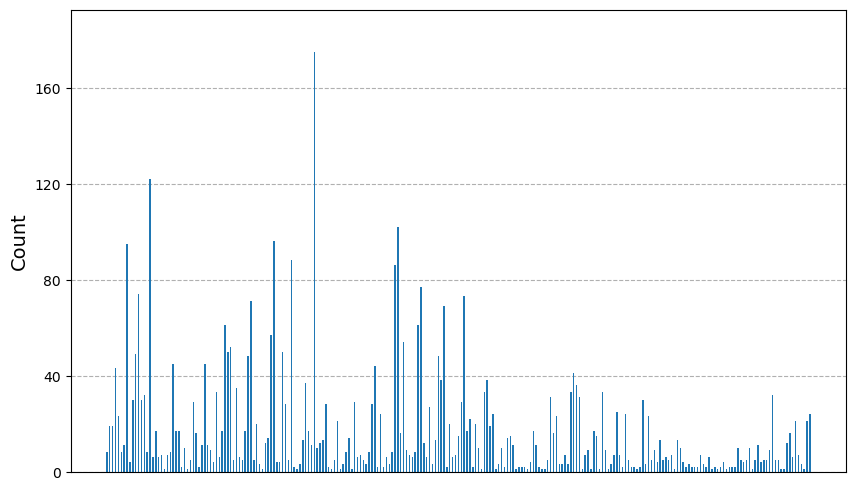

In [186]:
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram


sampler = SamplerV2()

job = sampler.run([measured_circuit], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_base = data['c'].get_counts()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_histogram(counts_base, bar_labels=False, ax=ax)
ax.set_xticks([])


[]

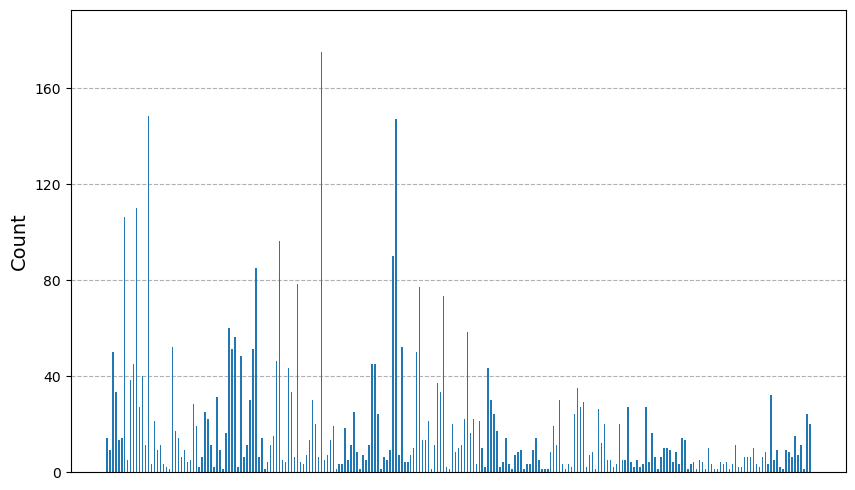

In [187]:
part_circuit_dec = partitioned_circuit_opt.decompose().decompose().decompose()

sampler = SamplerV2()

job = sampler.run([part_circuit_dec], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_part2 = data['result'].get_counts()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_histogram(data['result'].get_counts(),bar_labels=False,ax=ax)

ax.set_xticks([])


The histograms look very similar, but we would like to verify the circuit statistically, which we can do using a distance measurement.

We take a distance measurement for two distributions from the base circuit and take a norm difference, then compare the distribution with

In [188]:
def get_fidelity(counts1, counts2, shots):
    for key in counts1:
        digits = len(key)
        break
    norm = 0    
    max_string = '1'*digits
    integer = int(max_string, 2)
    for i in range(integer+1):
        binary = bin(i)
        binary = binary[2:]
        binary = '0'*(digits-len(binary)) + binary
        if binary in counts1:
            counts1_val = counts1[binary]/shots
        else:
            counts1_val = 0
        if binary in counts2:
            counts2_val = counts2[binary]/shots
        else:
            counts2_val = 0
        norm += np.abs(counts1_val - counts2_val)
    return norm**2



In [189]:
shots = 9192

job = sampler.run([measured_circuit], shots=shots)
job_result = job.result()
data = job_result[0].data

counts_base1 = data['c'].get_counts()

job = sampler.run([measured_circuit], shots=shots)
job_result = job.result()
data = job_result[0].data

counts_base2 = data['c'].get_counts()

fidelity_12 = get_fidelity(counts_base1, counts_base2, shots)

print(f'Fidelity between outcomes from two runs of base: {fidelity_12}')

job = sampler.run([part_circuit_dec], shots = shots)
job_result = job.result()
data = job_result[0].data

counts_part2 = data['result'].get_counts()

norm = get_fidelity(counts_base1, counts_part2, shots)

fidelity = get_fidelity(counts_base1, counts_part2, shots)

print(f'Fidelity between outcomes from base and partitioned circuit: {fidelity}')


Fidelity between outcomes from two runs of base: 0.02339648470195063
Fidelity between outcomes from base and partitioned circuit: 0.023797559992758666


These numbers should both be very close to 0 and very similar to each other! If not then something has gone wrong in the circuit extraction.